In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import math
import os
from itertools import product
from datetime import datetime
from dateutil.relativedelta import relativedelta
from quant_functions import anal_funcs, data_funcs

import yfinance as yf
## FRED 정보 수집
from fredapi import Fred

In [2]:
# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)

In [3]:
## 그리기 설정값
color_basic = "#3b4a6b" # 네이비 기본색
color_norm = "#f23557" # 진홍색 강조색
color_cont = "#22b2da" # 파란색 대비색
color_sub = "#ff6f3c" # 주황색 보조색
color_around = "#6E6E6E" # 회색 주변색
color_around2 = "#E0E0E0" # 밝은 회색 주변색

figsize=(12, 8)

##### Function #####

In [4]:
def simulate_portfolio_assets(asset_rets_df, weights_list, initial_investment=100):
    """
    n개의 자산에 대한 투자 비중에 따른 포트폴리오 시뮬레이션.

    Parameters:
        asset_returns (list of pd.Series): 각 자산의 수익률 시계열 데이터프레임.
        weights_list (list of list): 자산별 비중 리스트. 각 리스트의 합은 1이어야 함.
        initial_investment (float): 초기 투자 금액 (기본값: 100).

    Returns:
        pd.DataFrame: 각 비중 조합에 대한 포트폴리오 가치 시계열 데이터프레임.
    """
    asset_rets_list = [asset_rets_df[col] for col in asset_rets_df.columns]
    portfolio_values = {}
    for weights in weights_list:
        _weights = [i/sum(weights) for i in weights]
        # 포트폴리오 수익률 계산 (각 자산의 비중 곱)
        portfolio_returns = sum(w * r for w, r in zip(_weights, asset_rets_list))
        # 초기 투자 금액 기준 포트폴리오 가치 시계열 계산
        portfolio_cum_value = initial_investment * (1 + portfolio_returns).cumprod()
        portfolio_values[str(weights)] = portfolio_cum_value

    # 데이터프레임으로 변환
    portfolio_df = pd.DataFrame(portfolio_values)
    return portfolio_df

def split_time_series(df, n_days):
    split_days = n_days
    dfs = []
    for i in range(len(df)-split_days+1):
        dfs.append(df[i:split_days+i])
    return dfs

##### Data load

In [5]:
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

In [6]:
ticker_dict = {'SPY':'S&P500', 'QQQ':'Nasdaq100', 'IWM':'Russell2000',
               'VTI':'Total_US_Stock_Market', 'VT':'Total_World_Stock_Market', 'VEA':'Developed_Markets_ex_US', 'VWO':'Emerging_Markets',
               'SHV':'Super_Short_Term_Treasury', 'SHY':'Short_Term_Treasury', 'IEF':'Intermediate_Term_Treasury', 'TLT':'Long_Term_Treasury', 'TIP':'TIPS', 'BND':'Total_Bond_Market',
               'VNQ':'Real_Estate', 'RWX':'Global_Real_Estate',
               'GLD':'Gold', 'DBC':'Commodities', 'USO':'Oil', 'GSG':'Energy'}

In [15]:
dataset = data_funcs.get_merged_df('SPY', 'QQQ', 'IWM', 'VTI', 'VT', 'VEA', 'VWO', 'SHV', 'SHY','IEF', 'TLT', 'TIP', 'BND', 'VNQ', 'RWX', 'GLD', 'DBC', 'USO', 'GSG')
dataset = dataset[['SPY', 'QQQ', 'IWM', 'VTI', 'VT', 'VEA', 'VWO', 'SHV', 'SHY','IEF', 'TLT', 'TIP', 'BND', 'VNQ', 'RWX', 'GLD', 'DBC', 'USO', 'GSG']]

[*********************100%%**********************]  19 of 19 completed


In [16]:
## 무위험자산
dataset['CASH'] = range(len(dataset))
dataset['CASH'] = dataset['CASH'].apply(lambda x:((1.025)**(1/252))**x)

In [9]:
## 
datasemi = dataset[['SPY', 'QQQ', 'SHY','IEF', 'TLT', 'GLD', 'CASH']].copy()

In [10]:
## 데이터 설정값
ticker_A = 'QQQ'
ticker_B = 'TLT'

##### EDA

##### 상관계수

In [11]:
## corrset = dataset.rename(columns=ticker_dict).pct_change().corr()
## corrsemi = datasemi.rename(columns=ticker_dict).pct_change().corr()

corrset = dataset.pct_change().corr()
corrsemi = datasemi.pct_change().corr()

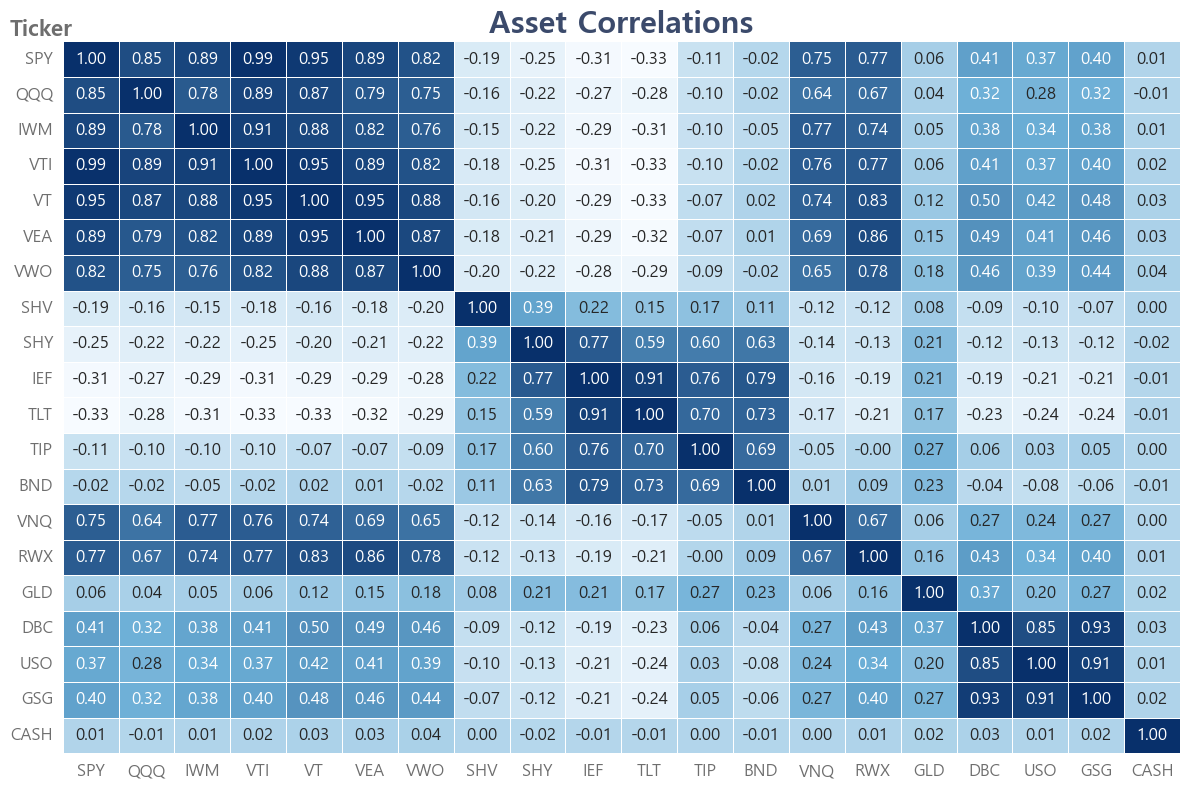

In [12]:
# 히트맵 시각화
plt.figure(figsize=figsize)

custom_colors = ["#F7FBFF", "#6BAED6", "#08306B"]
custom_cmap = LinearSegmentedColormap.from_list("custom", custom_colors)

sns.heatmap(corrset, annot=True, cmap=custom_cmap, fmt='.2f',
            linewidths=0.5, cbar_kws={"shrink": .8}, cbar=False, annot_kws={"size": 12})
plt.title('Asset Correlations', fontsize=22, fontweight="bold", color=color_basic)
plt.ylabel("Ticker", fontsize=16, labelpad=-45, fontweight="bold", color=color_around, loc="top", rotation=0)
plt.xlabel("")
plt.yticks(rotation=0, fontsize=12, color=color_around)
plt.xticks(rotation=0, fontsize=12, color=color_around)
plt.tight_layout()
plt.show()

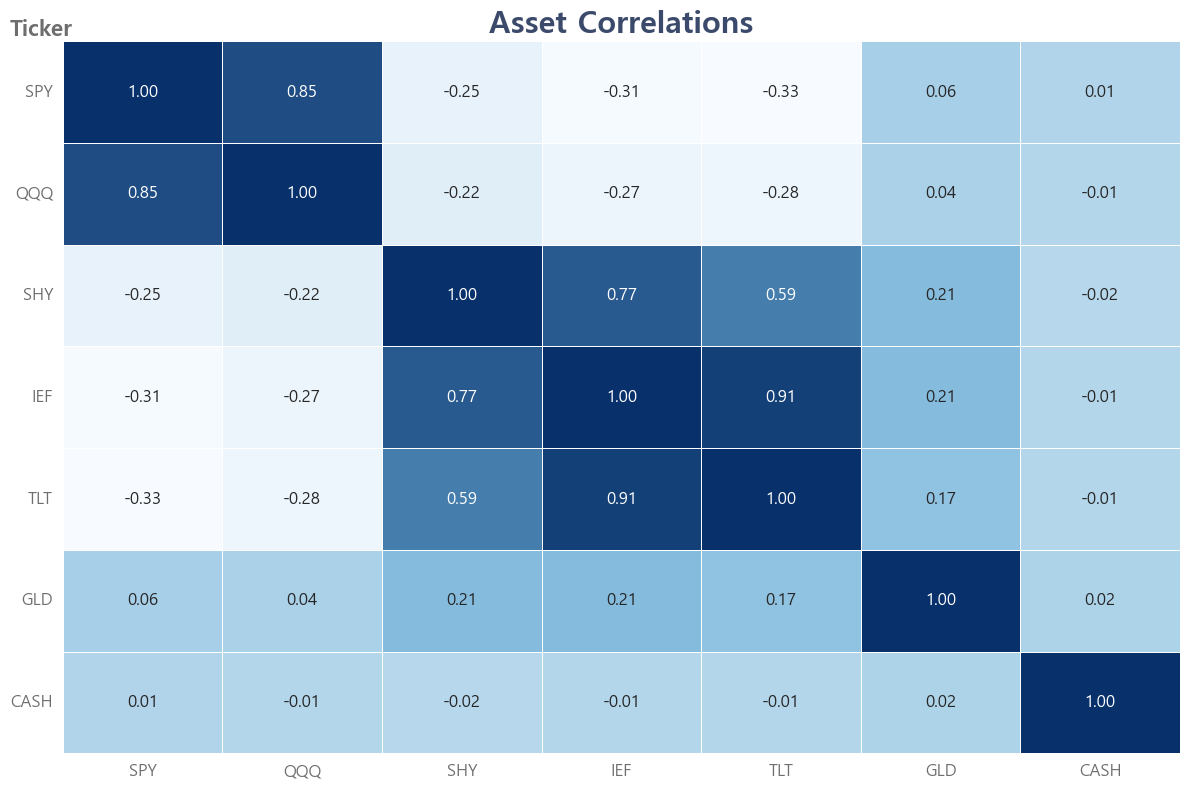

In [13]:
# 히트맵 시각화
plt.figure(figsize=figsize)

custom_colors = ["#F7FBFF", "#6BAED6", "#08306B"]
custom_cmap = LinearSegmentedColormap.from_list("custom", custom_colors)

sns.heatmap(corrsemi, annot=True, cmap=custom_cmap, fmt='.2f',
            linewidths=0.5, cbar_kws={"shrink": .8}, cbar=False, annot_kws={"size": 12})
plt.title('Asset Correlations', fontsize=22, fontweight="bold", color=color_basic)
plt.ylabel("Ticker", fontsize=16, labelpad=-45, fontweight="bold", color=color_around, loc="top", rotation=0)
plt.xlabel("")
plt.yticks(rotation=0, fontsize=12, color=color_around)
plt.xticks(rotation=0, fontsize=12, color=color_around)
plt.tight_layout()
plt.show()

In [25]:
dataset.dropna()

Ticker,SPY,QQQ,IWM,VTI,VT,VEA,VWO,SHV,SHY,IEF,TLT,TIP,BND,VNQ,RWX,GLD,DBC,USO,GSG,CASH
Date,,,,,,,,,,,,,,,,,,,,
2008-06-26,94.141037,39.633945,55.333874,47.536785,35.007038,25.825970,29.357176,91.968735,66.010300,60.143211,56.832191,69.012131,46.295216,29.883507,20.926907,90.610001,41.207394,904.960022,74.510002,1.462703
2008-06-27,93.627106,39.633945,55.389492,47.470272,34.950562,25.953735,29.598589,91.960365,66.042229,60.438656,57.498562,69.340424,46.417377,29.649731,20.782253,91.470001,41.316139,910.000000,74.730003,1.462846
2008-06-30,93.957497,39.217190,54.849346,47.374168,34.978794,26.118008,29.731997,91.993797,66.082115,60.479927,57.511032,69.404739,46.570049,29.690386,20.571831,91.400002,40.582073,909.280029,74.910004,1.462989
2008-07-01,94.251144,39.772861,54.889050,47.595921,34.668118,25.856384,28.912468,92.014748,66.065361,60.315811,57.374786,69.422279,46.536961,29.664972,20.365818,92.660004,41.298012,916.719971,74.949997,1.463133
2008-07-02,92.636009,38.817810,53.331909,46.620205,34.159763,25.418352,28.188229,92.023071,66.073296,60.460644,57.674782,69.856308,46.377522,29.299057,20.203623,93.169998,42.086452,934.719971,76.379997,1.463276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-09,604.679993,522.380005,237.729996,300.519989,122.820000,50.610001,47.509998,110.239998,82.199997,94.940002,93.519997,108.629997,73.489998,95.879997,24.150000,245.360001,22.120001,71.169998,21.150000,2.194706
2024-12-10,602.799988,520.599976,236.699997,299.390015,122.040001,50.240002,46.630001,110.239998,82.190002,94.769997,93.080002,108.589996,73.410004,94.489998,23.950001,248.589996,22.170000,71.400002,21.240000,2.194921
2024-12-11,607.460022,529.919983,237.770004,301.799988,122.970001,50.599998,46.709999,110.260002,82.169998,94.489998,92.199997,108.430000,73.250000,94.269997,23.959999,250.960007,22.450001,73.330002,21.500000,2.195136


In [23]:
anal_funcs.get_Vol_report(dataset.dropna(), 'a', rf=0)

,Return,Volatility,Volatility(Down),Residual,Beta,Sharpe_Ratio,Sortino_Ratio,Trainer_Ratio,Jensen_Alpha,Info_Ratio
Ticker,,,,,,,,,,
SPY,11.86,4.58,3.38,0.00,1.00,2.59,3.51,11.86,0.00,NaN
QQQ,16.93,5.38,3.65,2.15,0.78,3.15,4.63,21.65,7.65,2.36
IWM,9.06,6.10,4.28,2.91,0.67,1.49,2.12,13.55,1.13,-0.96
VTI,11.75,4.73,3.55,0.42,0.96,2.48,3.31,12.18,0.31,-0.27
VT,7.82,4.92,3.75,1.34,0.90,1.59,2.09,8.73,-2.80,-3.01
VEA,4.06,5.27,3.73,2.43,0.77,0.77,1.09,5.27,-5.09,-3.21
VWO,2.81,6.01,4.27,3.97,0.57,0.47,0.66,4.91,-3.98,-2.28
SHV,1.10,0.15,0.02,4.58,-0.69,7.50,56.71,-1.59,9.33,-2.35
SHY,1.32,0.41,0.27,4.61,-0.49,3.26,4.97,-2.67,7.19,-2.28


In [18]:
dataset

Ticker,SPY,QQQ,IWM,VTI,VT,VEA,VWO,SHV,SHY,IEF,TLT,TIP,BND,VNQ,RWX,GLD,DBC,USO,GSG,CASH
Date,,,,,,,,,,,,,,,,,,,,
1993-01-29,24.608629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
1993-02-01,24.783651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000098
1993-02-02,24.836157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000196
1993-02-03,25.098694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000294
1993-02-04,25.203714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-09,604.679993,522.380005,237.729996,300.519989,122.820000,50.610001,47.509998,110.239998,82.199997,94.940002,93.519997,108.629997,73.489998,95.879997,24.150000,245.360001,22.120001,71.169998,21.15,2.194706
2024-12-10,602.799988,520.599976,236.699997,299.390015,122.040001,50.240002,46.630001,110.239998,82.190002,94.769997,93.080002,108.589996,73.410004,94.489998,23.950001,248.589996,22.170000,71.400002,21.24,2.194921
2024-12-11,607.460022,529.919983,237.770004,301.799988,122.970001,50.599998,46.709999,110.260002,82.169998,94.489998,92.199997,108.430000,73.250000,94.269997,23.959999,250.960007,22.450001,73.330002,21.50,2.195136


##### 조합별 수익률

In [10]:
df = dataset[[ticker_A, ticker_B]].dropna()
df = df/df.iloc[0]

In [13]:
rets = df.pct_change().fillna(0)

In [14]:
result_df = simulate_portfolio_assets(rets, [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
result_df.columns = [ticker_A, '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', ticker_B]

In [258]:
# _df = result_df[[ticker_A, "5:5", ticker_B]].dropna().reset_index()
# _df = _df.melt(id_vars='Date', value_vars=_df.columns, var_name='Ticker', value_name='Value')

# plt.figure(figsize=figsize)
# colors = [color_norm, color_sub, color_cont]
# lineplot = sns.lineplot(data=_df, x='Date', y='Value', hue='Ticker', palette=colors, linestyle='-', linewidth=1)
# plt.ylabel("Return", fontsize=14, labelpad=-40, fontweight="bold", color=color_around, loc="top", rotation=0)
# plt.xlabel("")
# plt.yscale('log')
# plt.xticks(fontsize=12, color=color_around)
# plt.yticks([50, 100, 1000], ['50', '100', '1000'], fontsize=12, color=color_around)

# # 눈금과 축 간격 줄이기
# plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

# # 그리드 추가
# plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

# # 그래프 표시
# plt.tight_layout()
# plt.show()

##### 조합별 RR프로파일

In [ ]:
## sortino ratio
sort_df = anal_funcs.get_Vol_report(result_df, 'g', unit='daily', rf=0)

In [227]:
# # 색상 및 크기 설정
# colors = [color_norm, color_sub, color_sub, color_sub, color_sub, color_sub, color_sub, color_sub, color_sub, color_sub, color_cont]
# sizes = 500

# # 그래프 설정
# fig, ax = plt.subplots(figsize=figsize)

# # 점 그리기
# x = sort_df['Volatility']
# y = sort_df['Return']
# scatter = ax.scatter(x, y, c=colors, s=sizes, edgecolors="white", linewidth=2, alpha=0.9)


# # 데이터 레이블 추가
# labels = list(sort_df.index)
# for i, label in enumerate(labels):
#     plt.text(
#         x[i], y[i]-0.2, label, fontsize=12, ha="center", va="center", 
#         color="white", fontweight="bold", bbox=dict(facecolor=colors[i], edgecolor='none', alpha=0.8, boxstyle="round,pad=0.3")
#     )

# # % 단위를 추가하는 포맷터 함수 정의
# def percent_formatter(x, pos):
#     return f"{int(x)}%"

# # X축, Y축에 % 포맷터 적용
# plt.gca().xaxis.set_major_formatter(FuncFormatter(percent_formatter))
# plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
# # 눈금과 축 간격 줄이기
# plt.gca().tick_params(axis="x", pad=1)  # X축 눈금 패딩 조정
# plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

# # 축 설정
# plt.title("Return-Risk Profile : 2002~2024", fontsize=22, fontweight="bold", color=color_basic)
# plt.xlabel("Risk", fontsize=16, labelpad=-10, fontweight="bold", color=color_around, loc="right")
# plt.ylabel("Return", fontsize=16, labelpad=-50, fontweight="bold", color=color_around, loc="top", rotation=0)
# plt.xticks(fontsize=10, color=color_around)
# plt.yticks(fontsize=10, color=color_around)
# plt.xlim(2.9, 5.7)
# plt.ylim(2.4, 6.9)
# plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

# # 저장 및 출력
# plt.tight_layout()
# plt.show()


In [232]:
##### HRR

In [18]:
## 전고점대비 최대낙폭(MDD)
MDD, HRR = anal_funcs.get_MDD_report(result_df, 'g')

In [239]:
# _df = HRR[[ticker_A, "5:5", ticker_B]].dropna().reset_index()
# _df = _df.melt(id_vars='Date', value_vars=_df.columns, var_name='Ticker', value_name='Value')

# plt.figure(figsize=figsize)
# colors = [color_norm, color_sub, color_cont]
# lineplot = sns.lineplot(data=_df, x='Date', y='Value', hue='Ticker', palette=colors, linestyle='-', linewidth=1)
# plt.ylabel("MDD", fontsize=14, labelpad=-40, fontweight="bold", color=color_around, loc="top", rotation=0)
# plt.xlabel("")
# plt.xticks(fontsize=12, color=color_around)
# plt.yticks(fontsize=12, color=color_around)

# # 눈금과 축 간격 줄이기
# plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

# # 그리드 추가
# plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

# # 그래프 표시
# plt.tight_layout()
# plt.show()

##### 분할탐색

In [21]:
## data-split
df_ls = split_time_series(df, 5*252)

In [47]:
## calculate Rolling Returns
_ls = []
_idx = []
for _df in df_ls:
    _df = simulate_portfolio_assets(_df.pct_change().fillna(0), [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
    _df.columns = [ticker_A, '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', ticker_B]
    _ls.append([anal_funcs.cal_YRR(_df, col, method ='g', unit = 'daily') for col in _df.columns])
    _idx.append(_df.index[0])  
res = pd.DataFrame(_ls, columns = _df.columns, index=_idx)

In [206]:
# plt.figure(figsize=figsize)
# colors = [color_norm, color_sub, color_sub, color_sub, color_sub, color_sub, color_sub, color_sub, color_sub, color_sub, color_cont]
# boxplot = sns.boxplot(data=res, palette=colors, width=0.5, linewidth=1, linecolor= color_basic, boxprops=dict(edgecolor="black", linewidth=0))

# # 각 요소의 강조
# boxplot.set_title('Distribution of 5-Year Rolling Returns', fontsize=22, fontweight='bold', color=color_basic)
# plt.ylabel("Return", fontsize=14, labelpad=-40, fontweight="bold", color=color_around, loc="top", rotation=0)
# plt.xticks(fontsize=12, color=color_around)
# plt.yticks(fontsize=12, color=color_around)


# # 상자 위에 중앙값 추가
# medians = res.median()
# for i, median in enumerate(medians):
#     plt.text(i, median+0.25, f'{median:.2f}%', ha='center', va="center", fontsize=11,
#              color="white", fontweight="bold")


# # % 단위를 추가하는 포맷터 함수 정의
# def percent_formatter(x, pos):
#     return f"{int(x)}%"
# # X축, Y축에 % 포맷터 적용
# plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
# # 눈금과 축 간격 줄이기
# plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

# # 그리드 추가
# plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

# # 보조선 추가
# plt.axhline(y=0, color='lightcoral', linestyle='--', linewidth=1)

# # 그래프 표시
# plt.tight_layout()
# plt.show()

In [256]:
# _df = res[[ticker_A, '5:5', ticker_B]].reset_index()
# _df = _df.melt(id_vars='index', value_vars=_df.columns, var_name='Ticker', value_name='Value')

# plt.figure(figsize=figsize)
# colors = [color_norm, color_sub, color_cont]
# lineplot = sns.lineplot(data=_df, x='index', y='Value', hue='Ticker', palette=colors, linestyle='-', linewidth=1)
# plt.ylabel("Return", fontsize=14, labelpad=-40, fontweight="bold", color=color_around, loc="top", rotation=0)
# plt.xlabel("")
# plt.xticks(fontsize=12, color=color_around)
# plt.yticks(fontsize=12, color=color_around)


# # % 단위를 추가하는 포맷터 함수 정의
# def percent_formatter(x, pos):
#     return f"{int(x)}%"
# # X축, Y축에 % 포맷터 적용
# plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
# # 눈금과 축 간격 줄이기
# plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

# # 그리드 추가
# plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

# # 그래프 표시
# plt.tight_layout()
# plt.show()

##### 마무리

In [254]:
# _df = dataset[[ticker_A]].dropna().reset_index()
# _df = _df.melt(id_vars='Date', value_vars=_df.columns, var_name='Ticker', value_name='Value')

# plt.figure(figsize=figsize)
# colors = [color_norm, color_sub, color_cont]
# lineplot = sns.lineplot(data=_df, x='Date', y='Value', hue='Ticker', palette=colors, linestyle='-', linewidth=1)
# plt.ylabel("Return", fontsize=14, labelpad=-40, fontweight="bold", color=color_around, loc="top", rotation=0)
# plt.xlabel("")
# plt.yscale('log')
# plt.xticks(fontsize=12, color=color_around)
# plt.yticks([10, 100, 500], ['10', '100', '500'], fontsize=12, color=color_around)

# # 눈금과 축 간격 줄이기
# plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

# # 그리드 추가
# plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

# # 그래프 표시
# plt.tight_layout()
# plt.show()